In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tflite_support import metadata as _metadata

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Prepare training and validation datasets

In [2]:
batch_size = 32
img_height = 180
img_width = 180

directory = "/home/atti/Documents/PV162_CV/IMAGES/Coins/CZK/train/03Brno"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

Found 332 files belonging to 6 classes.
Using 266 files for training.
Found 332 files belonging to 6 classes.
Using 66 files for validation.


In [4]:
class_names = train_ds.class_names

print("Class names: " + str(class_names))
with open("labelmap.txt", "w") as f:
    for c in class_names:
        f.write(c)
        f.write('\n')

Class names: ['1', '10', '2', '20', '5', '50']


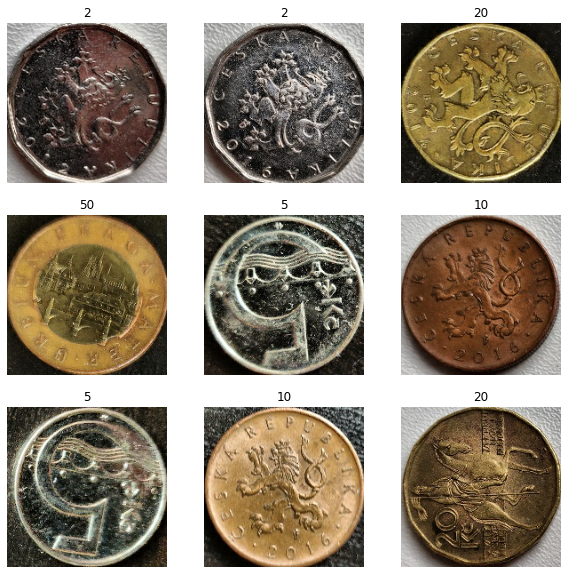

In [5]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalize the dataset

`[0, 255] -> [0, 1]`

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

## Data augmentation

 - randomly rotate by 180 degrees
 - randomly flip horizontally

In [8]:
data_augmentation_layer = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.25),
    ]
)

## Create the model

In [9]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

## Train the model

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.99):
            print("\nReached 93% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [11]:
epochs=70

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=[callbacks]
)

Epoch 1/70
9/9 [==============================] - 4s 365ms/step - loss: 1.9460 - accuracy: 0.1908 - val_loss: 150.0446 - val_accuracy: 0.2727
Epoch 2/70
9/9 [==============================] - 3s 342ms/step - loss: 1.7125 - accuracy: 0.3058 - val_loss: 36.5321 - val_accuracy: 0.1061
Epoch 3/70
9/9 [==============================] - 3s 346ms/step - loss: 1.7356 - accuracy: 0.2903 - val_loss: 146.2222 - val_accuracy: 0.3030
Epoch 4/70
9/9 [==============================] - 3s 357ms/step - loss: 1.5820 - accuracy: 0.2923 - val_loss: 87.3660 - val_accuracy: 0.3182
Epoch 5/70
9/9 [==============================] - 5s 511ms/step - loss: 1.3669 - accuracy: 0.3508 - val_loss: 129.3170 - val_accuracy: 0.4091
Epoch 6/70
9/9 [==============================] - 5s 531ms/step - loss: 1.2146 - accuracy: 0.4884 - val_loss: 74.9312 - val_accuracy: 0.5455
Epoch 7/70
9/9 [==============================] - 5s 535ms/step - loss: 1.0560 - accuracy: 0.5026 - val_loss: 206.4332 - val_accuracy: 0.5303
Epoch 8/7

## Visualize training results

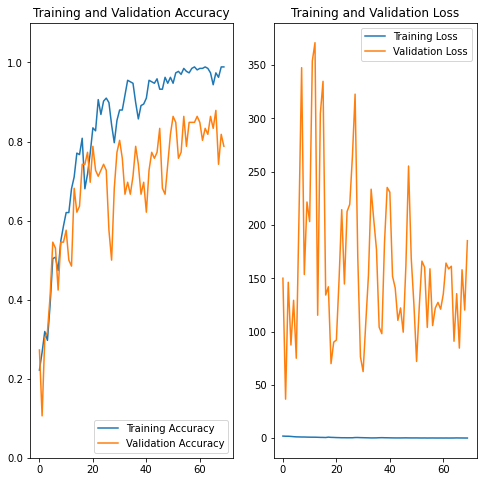

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.ylim([0,1.1])
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

[[8.9339325e-03 2.1116358e-17 9.9096656e-01 3.4375027e-16 9.9607154e-05
  1.6697342e-17]]
Predicted: 2 with a 99.10% confidence.
Correct: 2


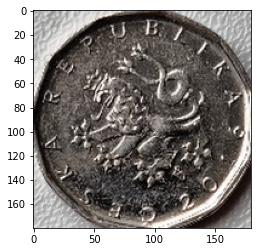

In [29]:
import random

class_num = 2

# get image path
img_dir_path = directory + "/" + str(class_names[class_num])
img_dir = [f for f in os.listdir(img_dir_path) if os.path.isfile(img_dir_path + "/" + f)]
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

# load image
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)/255.
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

# predict
predictions = model.predict(img_array_batch)

print(predictions)

# show results
plt.imshow(img_array)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print("Correct: " + str(class_names[class_num]))

## Export to .tflite

In [30]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpx2kxmpm6/assets
